<a href="https://colab.research.google.com/github/jperdomos/Parcial_2_TAM_2025_1/blob/main/Parcial2_TAM_2025_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Parcial 2 - Teoria de Aprendizaje de Máquina 2025-1

##**Integrantes:**

*   Jholman Dasney Meza
*   Campos Herney Tulcan
*   Juan Camilo Perdomo Soto

##**Profesor:** Andres Marino Álvarez Meza, Ph.D.

#Universidad Nacional de Colombia- Sede Manizales

# Análisis del dataset USPS con reducción de dimensionalidad y regresión logística

Este notebook realiza lo siguiente:

 Este notebook realiza:
# - Carga del dataset USPS
# - División en entrenamiento y prueba
# - Escalamiento con StandardScaler
# - Reducción de dimensionalidad con PCA y UMAP
# - Visualización 2D del espacio latente
# - Optimización de regresión logística con Optuna


#Punto B

In [ ]:
!pip install -q umap-learn scikit-learn matplotlib   ##Instalacion de librerias necesarias para el ejercicio

In [ ]:
#Librerias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


In [ ]:
# Cargar el dataset USPS desde OpenML

usps = fetch_openml('usps', version=1, as_frame=False)

# Separar los datos en variables (X) y etiquetas (y)

X, y = usps.data, usps.target.astype(int)


/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:1030: UserWarning: Version 1 of dataset USPS is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://api.openml.org/data/v1/download/18805612/USPS.arff
  warn(


In [ ]:
# Dividir conjunto de datos en train 70% y prueba 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Aplicar escalamiento estándar (media = 0, desviación estándar = 1) a los datos

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mostrar las dimensiones antes y después del escalamiento

print("X_train:", X_train.shape, "→", X_train_scaled.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test.shape, "→", X_test_scaled.shape)
print("y_test :", y_test.shape)

X_train: (6508, 256) → (6508, 256)
y_train: (6508,)
X_test : (2790, 256) → (2790, 256)
y_test : (2790,)


## Proyección con PCA y UMAP + visualización con miniaturas

In [ ]:
# Librerías
from sklearn.decomposition import PCA
import umap.umap_ as umap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [ ]:
# Aplicar PCA (Análisis de Componentes Principales) para reducir los datos a 2 dimensiones

pca = PCA(n_components=2, random_state=42)
X_pca_2D = pca.fit_transform(X_train_scaled)

# Aplicar UMAP (Uniform Manifold Approximation and Projection) con diferentes valores de n_neighbors

umap_embeddings = {}
neighbors_list = [5, 25, 60]

# Reducir la dimensionalidad con UMAP usando n_neighbors = {n}

for n in neighbors_list:
    reducer = umap.UMAP(n_components=2, n_neighbors=n, min_dist=0.1, random_state=42)
    umap_embeddings[n] = reducer.fit_transform(X_train_scaled)


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


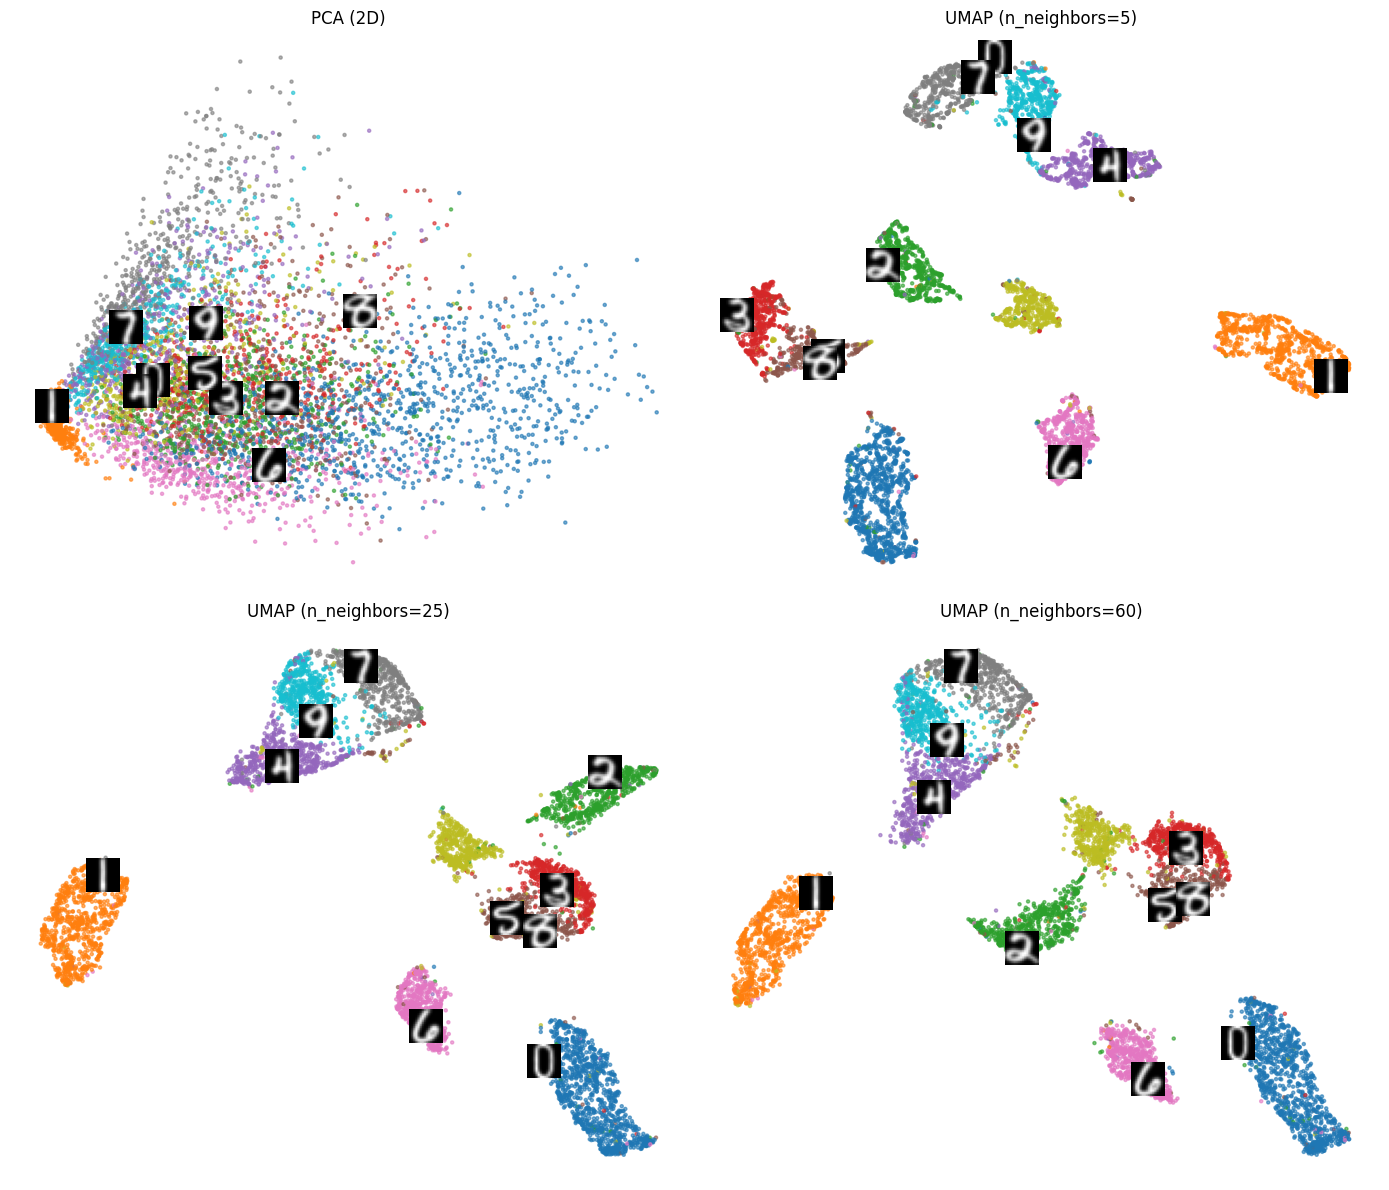

In [ ]:
# Visualización
def plot_latent_space(ax, embedding, labels, title, raw_images):
    """Visualiza un espacio latente en 2D con una muestra de imágenes por clase.

    Args:
        ax (matplotlib.axes.Axes): Ejes de Matplotlib sobre los cuales graficar.
        embedding (ndarray): Representación 2D obtenida con PCA o UMAP.
        labels (ndarray): Etiquetas de clase correspondientes a cada punto.
        title (str): Título del gráfico.
        raw_images (ndarray): Imágenes originales en formato plano (16x16 píxeles).

    Returns:
        None
    """
    ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=5, alpha=0.6)
    ax.set_title(title)
    ax.axis('off')

    # Añadir una imagen representativa por clase
    for digit in np.unique(labels):
        idx = np.where(labels == digit)[0]
        if len(idx) == 0:
            continue
        i = idx[len(idx)//2]
        image = raw_images[i].reshape(16, 16)  # USPS son 16x16
        im = OffsetImage(image, cmap='gray', zoom=1.5)
        ab = AnnotationBbox(im, (embedding[i, 0], embedding[i, 1]), frameon=False)
        ax.add_artist(ab)
# Generar una figura con 4 subgráficos para visualizar PCA y UMAP con diferentes n_neighbors

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

plot_latent_space(axes[0, 0], X_pca_2D, y_train, "PCA (2D)", X_train)
plot_latent_space(axes[0, 1], umap_embeddings[5], y_train, "UMAP (n_neighbors=5)", X_train)
plot_latent_space(axes[1, 0], umap_embeddings[25], y_train, "UMAP (n_neighbors=25)", X_train)
plot_latent_space(axes[1, 1], umap_embeddings[60], y_train, "UMAP (n_neighbors=60)", X_train)

plt.tight_layout()
plt.show()

## Análisis de los espacios proyectados

PCA genera una representación dispersa donde muchas clases se solapan ya que solo conserva la varianza global sin capturar bien la estructura local, el UMAP con pocos vecinos forma grupos bien separados y compactos lo que facilita ver las clases aunque puede ser sensible al ruido.

Al aumentar `n_neighbors` a 25 o 60 los grupos se vuelven más amplios y estables pero algunas clases cercanas tienden a fusionarse como el 5 y el 8, es decir que el número de vecinos en UMAP cambia la forma en que se estructura el espacio latente permitiendo controlar si se prioriza la separación local o la coherencia global


#Punto C

##LogisticRegression

In [ ]:
!pip install -q optuna

import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


In [ ]:
def objective(trial):
   """Función objetivo para la optimización de regresión logística con Optuna.

    Realiza una búsqueda de hiperparámetros utilizando validación cruzada
    para maximizar la precisión (accuracy) del modelo.

    Args:
        trial (optuna.trial.Trial): Objeto de Optuna que sugiere combinaciones de hiperparámetros.

    Returns:
        float: Precisión promedio del modelo en validación cruzada.
    """
    C = trial.suggest_float('C', 1e-2, 10.0, log=True)
    tol = trial.suggest_float('tol', 1e-4, 1e-2, log=True)
    max_iter = trial.suggest_int('max_iter', 200, 500, step=100)
    solver = trial.suggest_categorical('solver', ['lbfgs'])

    model = LogisticRegression(
        C=C,
        tol=tol,
        max_iter=max_iter,
        solver=solver,
        multi_class='multinomial',
        penalty='l2',
        random_state=42,
        n_jobs=-1
    )

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy').mean()
    return score




In [ ]:
# Ejecutar la optimización con 20 ensayos para encontrar los mejores hiperparámetros

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-07-18 04:02:45,720] A new study created in memory with name: no-name-605ab1ab-262d-4b12-8579-01162e575dbd
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-07-18 04:02:53,926] Tri

In [ ]:
print("Mejores hiperparámetros encontrados:")
for key, val in study.best_params.items():
    print(f"{key}: {val}")

Mejores hiperparámetros encontrados:
C: 0.21720108054238565
tol: 0.001017420205368912
max_iter: 200
solver: lbfgs


In [ ]:
# Entrenar y evaluar el modelo en el conjunto de prueba usando los mejores hiperparámetros encontrados

best_params = study.best_params

best_logreg = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    tol=best_params['tol'],
    max_iter=best_params['max_iter'],
    multi_class='multinomial',
    penalty='l2',
    random_state=42,
    n_jobs=-1
)

best_logreg.fit(X_train_scaled, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=0.21720108054238565, max_iter=200,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   tol=0.001017420205368912)

 Accuracy: 0.9505
 F1-score (macro): 0.9465
 Precision (macro): 0.9463
 Recall (macro): 0.9467

 Reporte detallado por clase:
              precision    recall  f1-score   support

           1     0.9763    0.9721    0.9742       466
           2     0.9816    0.9816    0.9816       381
           3     0.9234    0.9068    0.9150       279
           4     0.9388    0.9312    0.9350       247
           5     0.9228    0.9336    0.9282       256
           6     0.9346    0.9302    0.9324       215
           7     0.9643    0.9720    0.9681       250
           8     0.9510    0.9790    0.9648       238
           9     0.9231    0.9057    0.9143       212
          10     0.9476    0.9553    0.9514       246

    accuracy                         0.9505      2790
   macro avg     0.9463    0.9467    0.9465      2790
weighted avg     0.9505    0.9505    0.9505      2790



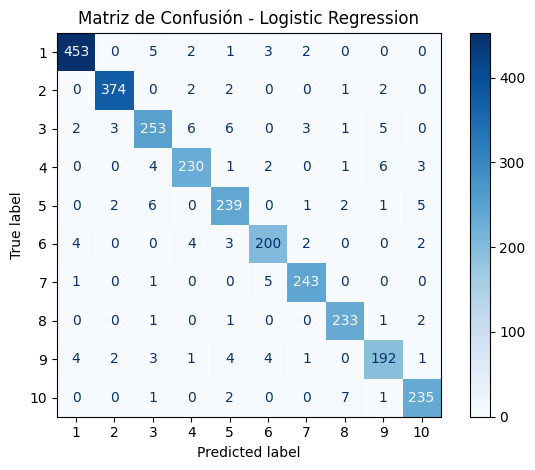

In [ ]:
# Evaluación del modelo con métricas de clasificación

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Generar predicciones sobre el conjunto de prueba

y_pred = best_logreg.predict(X_test_scaled)

print(f" Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f" F1-score (macro): {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f" Precision (macro): {precision_score(y_test, y_pred, average='macro'):.4f}")
print(f" Recall (macro): {recall_score(y_test, y_pred, average='macro'):.4f}")

print("\n Reporte detallado por clase:")
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_estimator(
    best_logreg,
    X_test_scaled,
    y_test,
    display_labels=np.unique(y_test),
    cmap="Blues"
)
plt.title("Matriz de Confusión - Logistic Regression")
plt.tight_layout()
plt.show()


In [ ]:
# Curvas ROC multiclase
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarizar etiquetas
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_logreg.predict_proba(X_test_scaled)

# Calcular FPR, TPR, AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


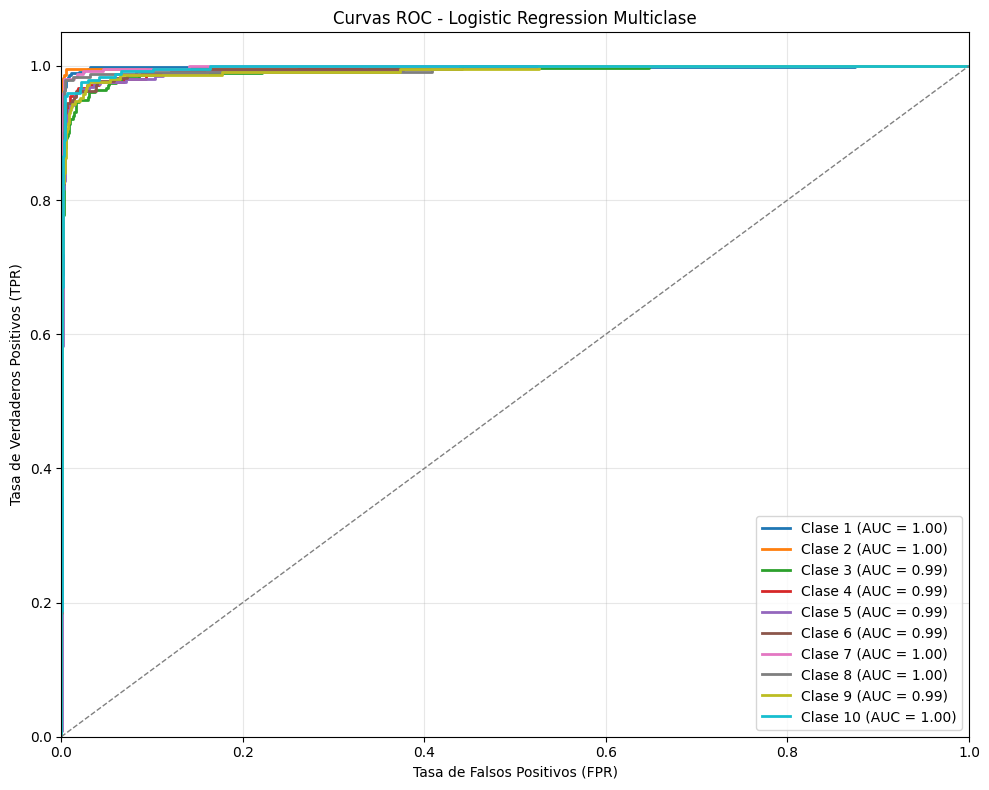

In [ ]:
# Gráfico de curvas ROC

plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Clase {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC - Logistic Regression Multiclase")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


##RandomForestClassifier

In [ ]:
import optuna
from optuna.pruners import MedianPruner
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def rf_oob_objective(trial):
    """
    Función objetivo para optimizar hiperparámetros de un Random Forest usando Optuna y puntaje OOB (Out-Of-Bag).

    Args:
        trial (optuna.trial.Trial): Objeto de prueba de Optuna que sugiere valores de hiperparámetros.

    Returns:
        float: Puntaje OOB obtenido luego de entrenar el modelo con los hiperparámetros sugeridos.
    """
    n_estimators      = trial.suggest_int('n_estimators', 50, 200)
    max_depth         = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 8)
    min_samples_leaf  = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features      = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

# Entrena un modelo Random Forest con los mejores hiperparámetros encontrados por Optuna
# utilizando el puntaje OOB como métrica de evaluación.


    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        oob_score=True,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_train_scaled, y_train)
    return rf.oob_score_

    score = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score


In [ ]:
study_rf = optuna.create_study(
    direction='maximize',
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=0)
)

study_rf.optimize(rf_oob_objective, n_trials=15)

[I 2025-07-18 04:05:57,515] A new study created in memory with name: no-name-32a4aec7-65e9-4d96-b8da-f74134777d92
[I 2025-07-18 04:06:06,283] Trial 0 finished with value: 0.9522126613398894 and parameters: {'n_estimators': 58, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.9522126613398894.
[I 2025-07-18 04:06:14,810] Trial 1 finished with value: 0.9522126613398894 and parameters: {'n_estimators': 87, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9522126613398894.
[I 2025-07-18 04:06:21,106] Trial 2 finished with value: 0.952980946527351 and parameters: {'n_estimators': 108, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.952980946527351.
[I 2025-07-18 04:06:24,393] Trial 3 finished with value: 0.949139520590043 and parameters: {'n_estimators': 66, 'max_depth': 21, 'min_sam

In [ ]:
print("Mejores hiperparámetros encontrados:")
for k, v in study_rf.best_params.items():
    print(f"  {k}: {v}")

Mejores hiperparámetros encontrados:
  n_estimators: 105
  max_depth: 17
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: sqrt


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

rf = RandomForestClassifier(
    **study_rf.best_params,
    oob_score=True,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)


RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=105, n_jobs=-1, oob_score=True,
                       random_state=42)

In [ ]:
# Realiza predicciones sobre el conjunto de prueba.
y_pred = rf.predict(X_test_scaled)

# Métricas
print(f"Accuracy          : {accuracy_score(y_test,   y_pred):.4f}")
print(f"Precision (macro) : {precision_score(y_test, y_pred, average='macro'):.4f}")
print(f"Recall (macro)    : {recall_score(y_test,  y_pred, average='macro'):.4f}")
print(f"F1‑score (macro)  : {f1_score(y_test,   y_pred, average='macro'):.4f}")

Accuracy          : 0.9559
Precision (macro) : 0.9537
Recall (macro)    : 0.9503
F1‑score (macro)  : 0.9518


In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Muestra el desglose de métricas por clase.
print("\nReporte detallado por clase:")
print(classification_report(y_test, y_pred, digits=4))



Reporte detallado por clase:
              precision    recall  f1-score   support

           1     0.9663    0.9850    0.9756       466
           2     0.9817    0.9843    0.9830       381
           3     0.9441    0.9677    0.9558       279
           4     0.9745    0.9271    0.9502       247
           5     0.9173    0.9531    0.9349       256
           6     0.9330    0.9070    0.9198       215
           7     0.9758    0.9680    0.9719       250
           8     0.9740    0.9454    0.9595       238
           9     0.9412    0.9057    0.9231       212
          10     0.9291    0.9593    0.9440       246

    accuracy                         0.9559      2790
   macro avg     0.9537    0.9503    0.9518      2790
weighted avg     0.9562    0.9559    0.9558      2790



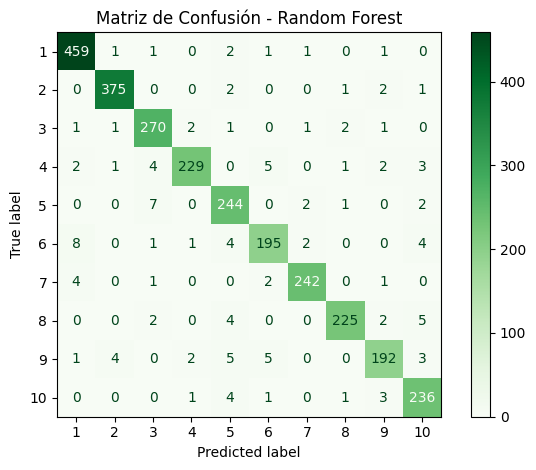

In [ ]:
# Matriz de confusión para Random Forest
ConfusionMatrixDisplay.from_estimator(
    rf,
    X_test_scaled,
    y_test,
    display_labels=np.unique(y_test),
    cmap="Greens"
)
plt.title("Matriz de Confusión - Random Forest")
plt.tight_layout()
plt.show()

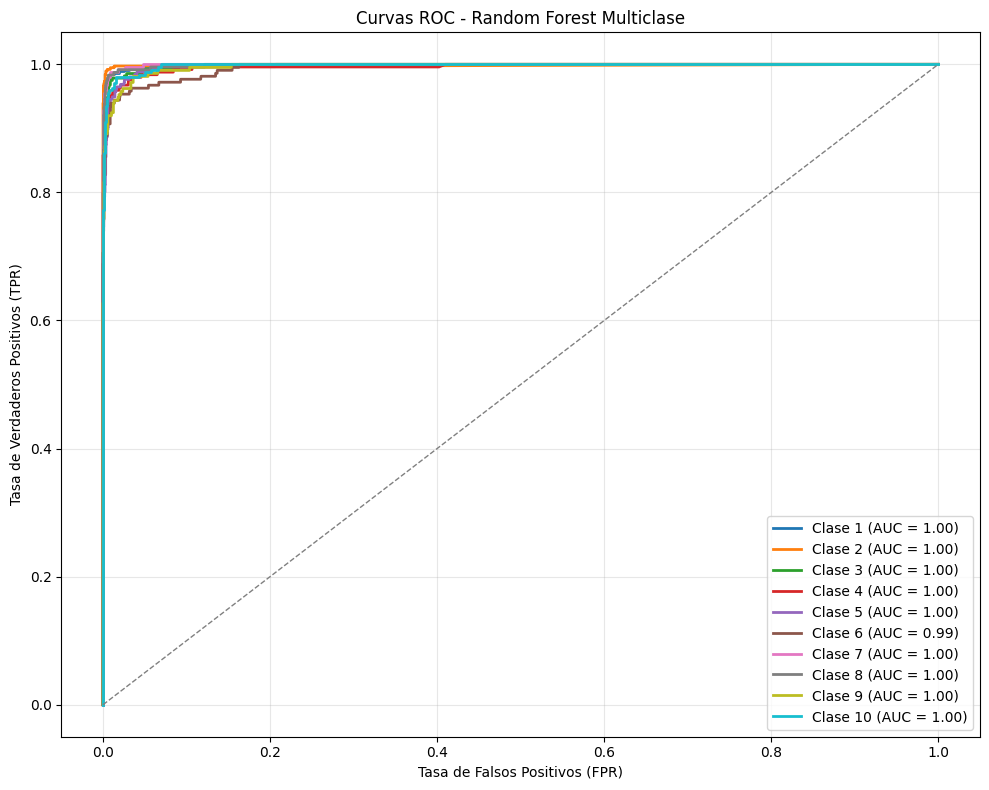

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Define las clases y binariza las etiquetas
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Obtiene las probabilidades predichas
y_score = rf.predict_proba(X_test_scaled)

# Calcula FPR, TPR y AUC para cada clase
fpr_rf = {}
tpr_rf = {}
roc_auc_rf = {}
for i in range(len(classes)):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc_rf[i]          = auc(fpr_rf[i], tpr_rf[i])

# Dibuja las curvas ROC
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    plt.plot(
        fpr_rf[i],
        tpr_rf[i],
        lw=2,
        label=f"Clase {classes[i]} (AUC = {roc_auc_rf[i]:.2f})"
    )

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC - Random Forest Multiclase")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


##CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Reajustar dimensiones para CNN: (N, 1, 16, 16)
X_train_tensor = torch.tensor(X_train_scaled.reshape(-1, 1, 16, 16), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.reshape(-1, 1, 16, 16), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train - 1, dtype=torch.long)
y_test_tensor = torch.tensor(y_test - 1, dtype=torch.long)


# DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
class SimpleCNN(nn.Module):
    """
    Red neuronal convolucional simple para clasificación de imágenes USPS.

    Atributos:
        conv1 (nn.Conv2d): Primera capa convolucional.
        conv2 (nn.Conv2d): Segunda capa convolucional.
        pool (nn.MaxPool2d): Capa de agrupamiento.
        dropout (nn.Dropout): Capa de regularización por abandono.
        fc1 (nn.Linear): Capa totalmente conectada intermedia.
        fc2 (nn.Linear): Capa de salida con 10 neuronas (una por dígito).
    """

    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 clases USPS

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 16x8x8
        x = self.pool(F.relu(self.conv2(x)))  # 32x4x4
        x = x.view(-1, 32 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Época {epoch+1}/{n_epochs}, Pérdida: {total_loss:.4f}")


Época 1/30, Pérdida: 72.6910
Época 2/30, Pérdida: 25.6240
Época 3/30, Pérdida: 16.7905
Época 4/30, Pérdida: 13.8206
Época 5/30, Pérdida: 11.7604
Época 6/30, Pérdida: 10.1241
Época 7/30, Pérdida: 8.8373
Época 8/30, Pérdida: 7.3723
Época 9/30, Pérdida: 6.5566
Época 10/30, Pérdida: 6.5533
Época 11/30, Pérdida: 5.4218
Época 12/30, Pérdida: 5.5183
Época 13/30, Pérdida: 4.9123
Época 14/30, Pérdida: 4.1835
Época 15/30, Pérdida: 3.9447
Época 16/30, Pérdida: 3.8644
Época 17/30, Pérdida: 3.5298
Época 18/30, Pérdida: 2.8584
Época 19/30, Pérdida: 3.1709
Época 20/30, Pérdida: 2.8430
Época 21/30, Pérdida: 2.8022
Época 22/30, Pérdida: 2.3540
Época 23/30, Pérdida: 2.7725
Época 24/30, Pérdida: 1.7951
Época 25/30, Pérdida: 2.0117
Época 26/30, Pérdida: 2.1262
Época 27/30, Pérdida: 2.1490
Época 28/30, Pérdida: 2.0413
Época 29/30, Pérdida: 1.6652
Época 30/30, Pérdida: 1.9249


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay

# Evaluar modelo CNN sobre test
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())


In [ ]:
print(f"Accuracy          : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro) : {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (macro)    : {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1‑score (macro)  : {f1_score(y_true, y_pred, average='macro'):.4f}")


Accuracy          : 0.9846
Precision (macro) : 0.9847
Recall (macro)    : 0.9825
F1‑score (macro)  : 0.9835


In [ ]:
print("\nReporte detallado por clase:")
print(classification_report(y_true, y_pred, digits=4))



Reporte detallado por clase:
              precision    recall  f1-score   support

           0     0.9810    0.9957    0.9883       466
           1     0.9921    0.9921    0.9921       381
           2     0.9788    0.9928    0.9858       279
           3     0.9756    0.9717    0.9736       247
           4     0.9921    0.9805    0.9862       256
           5     0.9810    0.9628    0.9718       215
           6     0.9920    0.9920    0.9920       250
           7     0.9752    0.9916    0.9833       238
           8     0.9951    0.9575    0.9760       212
           9     0.9838    0.9878    0.9858       246

    accuracy                         0.9846      2790
   macro avg     0.9847    0.9825    0.9835      2790
weighted avg     0.9846    0.9846    0.9846      2790



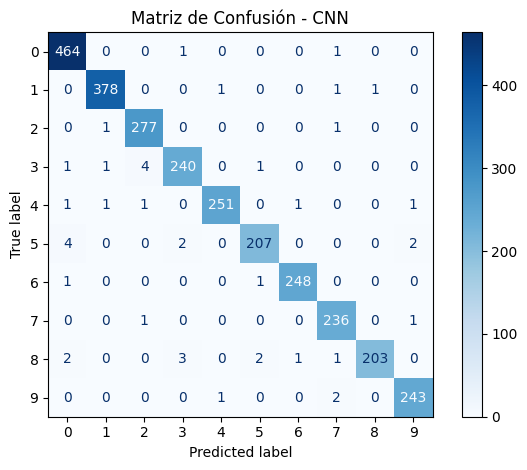

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=np.arange(0, 10),
    cmap="Blues"
)
plt.title("Matriz de Confusión - CNN")
plt.tight_layout()
plt.show()


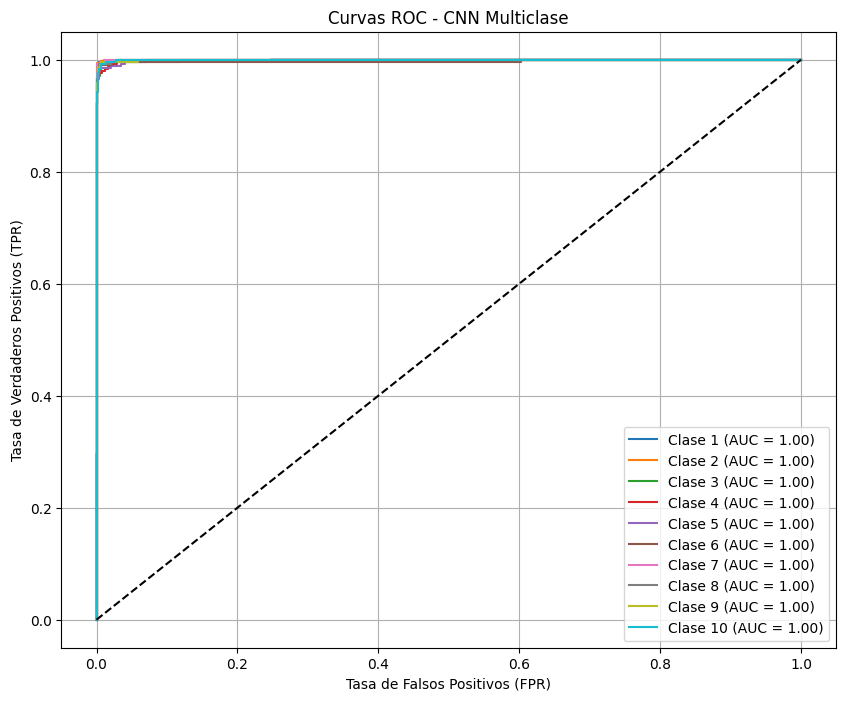

In [ ]:
# One-hot encoding
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f"Clase {i+1} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC - CNN Multiclase")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
!pip install -q streamlit streamlit_option_menu pyngrok



Guarda todas las figuras necesarias para el dashboard, incluyendo proyecciones PCA/UMAP,
matrices de confusión y curvas ROC para los modelos LR, RF y CNN.


Mounted at /content/drive
✅ Todas las figuras guardadas en: /content/drive/MyDrive/Parcial2_DashboardAssets


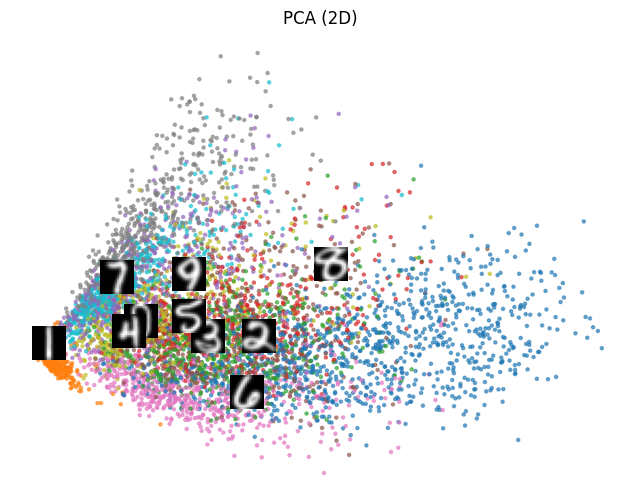

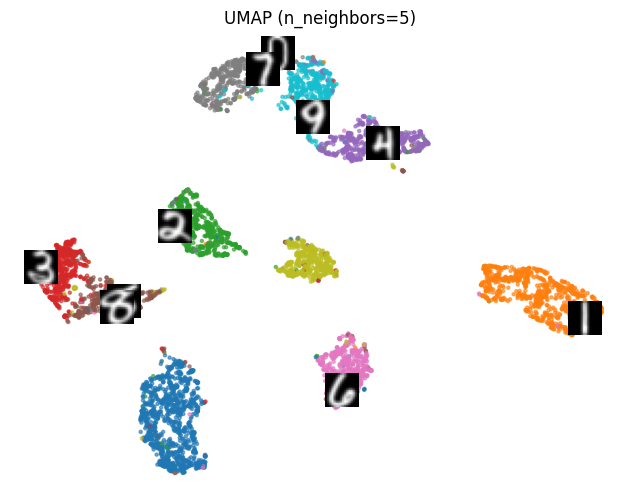

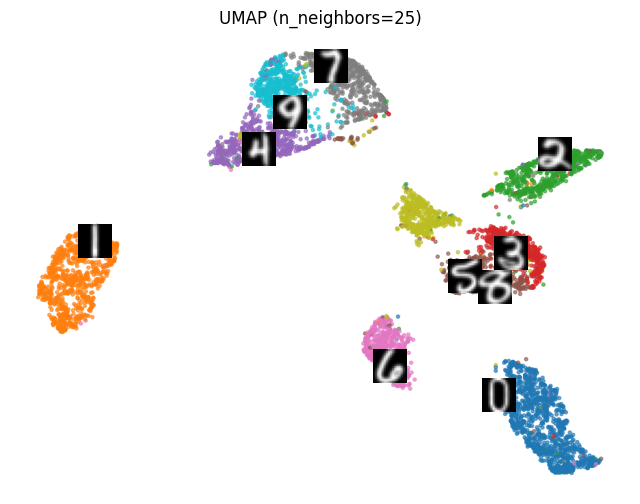

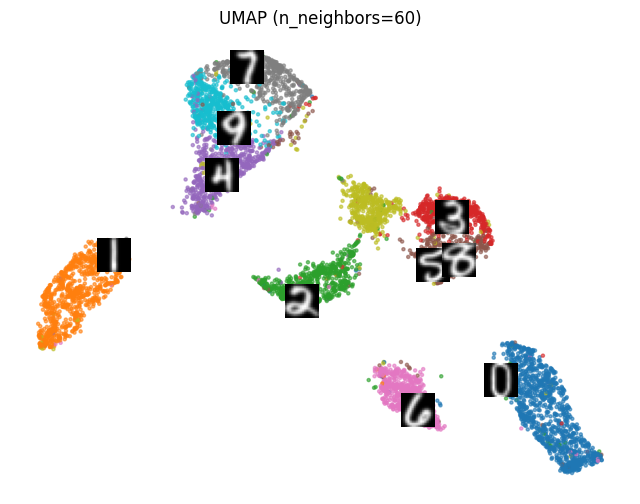

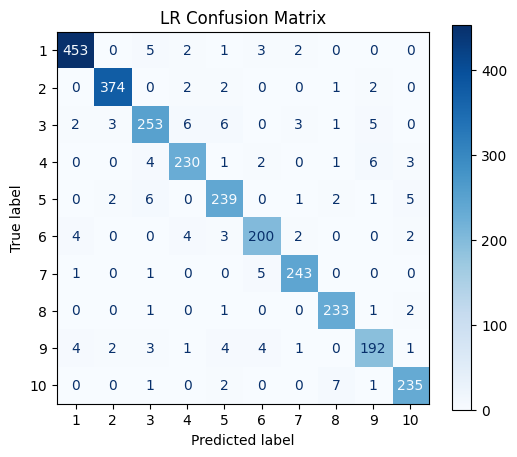

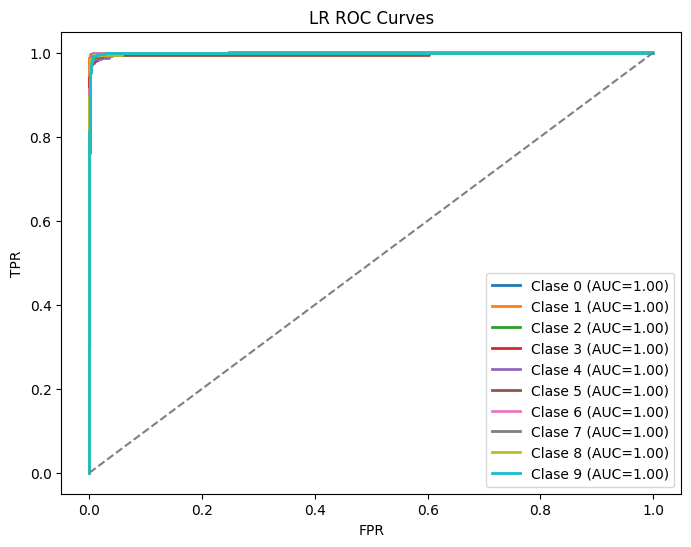

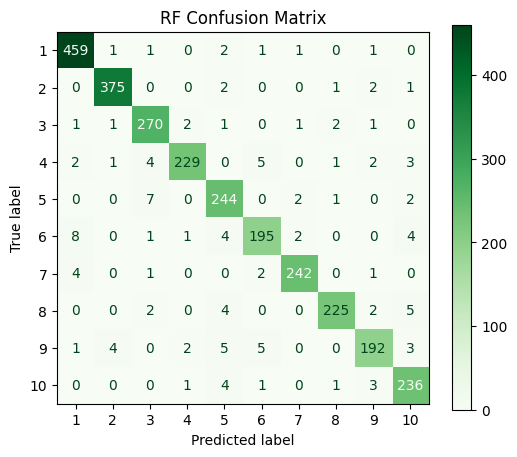

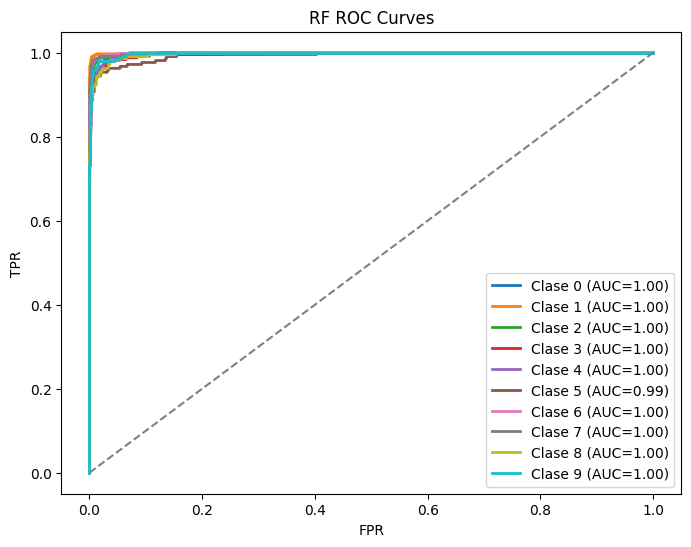

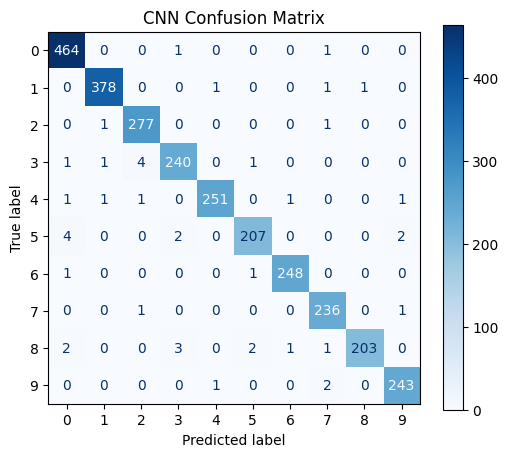

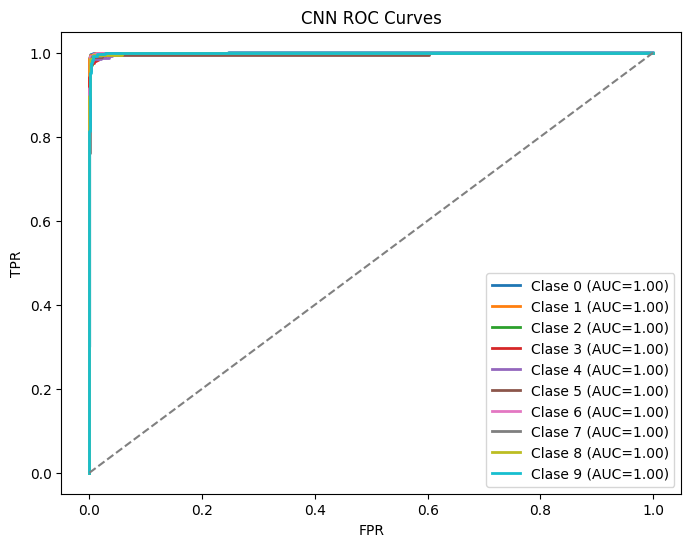

In [ ]:
# ——— GUARDAR FIGURAS PARA DASHBOARD ———

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Crear carpeta de destino
import os
asset_dir = '/content/drive/MyDrive/Parcial2_DashboardAssets'
os.makedirs(asset_dir, exist_ok=True)

# Guardar la proyección PCA
fig_pca, ax_pca = plt.subplots(figsize=(8,6))
plot_latent_space(ax_pca, X_pca_2D, y_train, "PCA (2D)", X_train)
fig_pca.savefig(os.path.join(asset_dir, 'pca_projection.png'),
                dpi=300, bbox_inches='tight')

# Guardar las proyecciones UMAP para cada n_neighbors
for n in neighbors_list:
    emb = umap_embeddings[n]
    fig_umap, ax_umap = plt.subplots(figsize=(8,6))
    plot_latent_space(ax_umap, emb, y_train,
                      f"UMAP (n_neighbors={n})", X_train)
    fig_umap.savefig(os.path.join(asset_dir, f'umap_n{n}.png'),
                     dpi=300, bbox_inches='tight')

# Guardar matriz de confusión y ROC de LogisticRegression
fig_lr_cm, ax_lr_cm = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay.from_estimator(
    best_logreg, X_test_scaled, y_test,
    display_labels=np.unique(y_test), cmap="Blues", ax=ax_lr_cm
)
ax_lr_cm.set_title("LR Confusion Matrix")
fig_lr_cm.savefig(os.path.join(asset_dir, 'lr_confusion.png'),
                  dpi=300, bbox_inches='tight')

fig_lr_roc, ax_lr_roc = plt.subplots(figsize=(8,6))
for i in range(len(classes)):
    ax_lr_roc.plot(fpr[i], tpr[i],
                   label=f"Clase {classes[i]} (AUC={roc_auc[i]:.2f})", lw=2)
ax_lr_roc.plot([0,1],[0,1],'--', color='gray')
ax_lr_roc.set(title="LR ROC Curves", xlabel="FPR", ylabel="TPR")
ax_lr_roc.legend(loc='lower right')
fig_lr_roc.savefig(os.path.join(asset_dir, 'lr_roc.png'),
                   dpi=300, bbox_inches='tight')

# Guardar para RandomForest
fig_rf_cm, ax_rf_cm = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay.from_estimator(
    rf, X_test_scaled, y_test,
    display_labels=np.unique(y_test), cmap="Greens", ax=ax_rf_cm
)
ax_rf_cm.set_title("RF Confusion Matrix")
fig_rf_cm.savefig(os.path.join(asset_dir, 'rf_confusion.png'),
                  dpi=300, bbox_inches='tight')

fig_rf_roc, ax_rf_roc = plt.subplots(figsize=(8,6))
for i in range(len(classes)):
    ax_rf_roc.plot(fpr_rf[i], tpr_rf[i],
                   label=f"Clase {classes[i]} (AUC={roc_auc_rf[i]:.2f})", lw=2)
ax_rf_roc.plot([0,1],[0,1],'--', color='gray')
ax_rf_roc.set(title="RF ROC Curves", xlabel="FPR", ylabel="TPR")
ax_rf_roc.legend(loc='lower right')
fig_rf_roc.savefig(os.path.join(asset_dir, 'rf_roc.png'),
                   dpi=300, bbox_inches='tight')

# Guardar para la CNN
fig_cnn_cm, ax_cnn_cm = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=np.arange(0,10), cmap="Blues", ax=ax_cnn_cm
)
ax_cnn_cm.set_title("CNN Confusion Matrix")
fig_cnn_cm.savefig(os.path.join(asset_dir, 'cnn_confusion.png'),
                   dpi=300, bbox_inches='tight')

fig_cnn_roc, ax_cnn_roc = plt.subplots(figsize=(8,6))
for i in range(10):
    ax_cnn_roc.plot(fpr[i], tpr[i],
                    label=f"Clase {i} (AUC={roc_auc[i]:.2f})", lw=2)
ax_cnn_roc.plot([0,1],[0,1],'--', color='gray')
ax_cnn_roc.set(title="CNN ROC Curves", xlabel="FPR", ylabel="TPR")
ax_cnn_roc.legend(loc='lower right')
fig_cnn_roc.savefig(os.path.join(asset_dir, 'cnn_roc.png'),
                    dpi=300, bbox_inches='tight')

print("✅ Todas las figuras guardadas en:", asset_dir)
